## Assignment 5

This assignment is based on Bayesian statistics to carry out Stock return analysis.

## Learning outcomes

- Bayesian analysis for stock return data
- Build models for different distributions of data
- Compare models

In this assignment, you will use the Baysesian approach for analysis of stock return data.
In particular, you will model the data as a normal distribution and will estimate distribution parameters using Markov chain Monte Carlo technique (MCMC).

The MCMC sampler draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values.
It is recommended to use PyMC library for these computations; PyMC is a Python library for Bayesian analysis.

__NOTE__: The 'data.csv' file included with the assignment contains the data.
The data were downloaded from Quandl, the code used to download data and calculate daily return is provided.    
Use that file instead if you aren't able to read the data, or if you have reached the limit for calls to the API.

__Getting data from Quandl__ 
To download stock data from Quandl you should create an account for quandl (https://www.quandl.com/).

Quandl is a platform for financial, economic, and alternative data that serves investment professionals. Quandl sources data from over 500 publishers. All Quandl's data are accessible via an API. API access is possible through packages for multiple programming languages including R, Python.

Required imports for this project are given below.  Make sure you have all libraries required for this project installed.  You may use _conda_ or _pip_ based on your set up.


In [ ]:
# Assignment5
# Userid:wjing
# Student name: Jing Wang

In [368]:
#required imports

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt
import seaborn as sns
from datetime import datetime

from scipy import stats
import arviz as az
from theano import shared
from sklearn import preprocessing
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots


## Get the data:
pd.core.common.is_list_like = pd.api.types.is_list_like # resolves datareader error
from pandas_datareader import data
# For all libraries please install the necessary libraries 
#If the above fails, you might need to do something like this:
#This is to show how you install pandas-datareader, you might need to do this for all libraries
#conda install pandas-datareader
#or
#pip install pandas-datareader
#Depending on your setup

from IPython.display import Image
from datetime import datetime
%matplotlib inline

After installing the necessary libraries, we will proceed to download the data.
You might have to set an environment variable for pymc3 package.  
You can do this by    
For linux:
export mkl_threading_layer=gnu or set this in your bashrc file.

For windows:
Add it in your environment variables

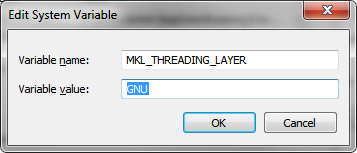

### Returns
Extract historical data for Apple (AAPL) [2015 - 2016], calculate daily returns, and estimate the mean daily return. Remove NaN from dataset. Plot histogram of daily returns.

Use code below to download data.

For this you will need to install the library quandl:    
conda install -c anaconda quandl

You will also need an API Key that is generated when you create an account.  

In [369]:
import quandl
import pandas as pd
quandl.ApiConfig.api_key = '4XWVLg3qR7xBfGT4PF3i'

data= quandl.get('WIKI/AAPL', start_date='2015-1-1', end_date='2016-12-31')
print(type(data))

data.to_csv('data.csv')

returns=data['Adj. Close'].pct_change()

returns = returns.dropna()*100



<class 'pandas.core.frame.DataFrame'>


#### Question 1

1. Plot the returns and draw a histogram to see the distribution


In [ ]:
# YOUR CODE HERE

In [370]:
#true population mean and standard deviation
return_mean=returns.mean()
return_sd=returns.std()
print("mean of return is ", return_mean)
print("std of return is ", return_sd)

mean of return is  0.03166161960434799
std of return is  1.579874157778189


In [371]:
returns.head()

Date
2015-01-05   -2.817159
2015-01-06    0.009412
2015-01-07    1.402221
2015-01-08    3.842227
2015-01-09    0.107248
Name: Adj. Close, dtype: float64

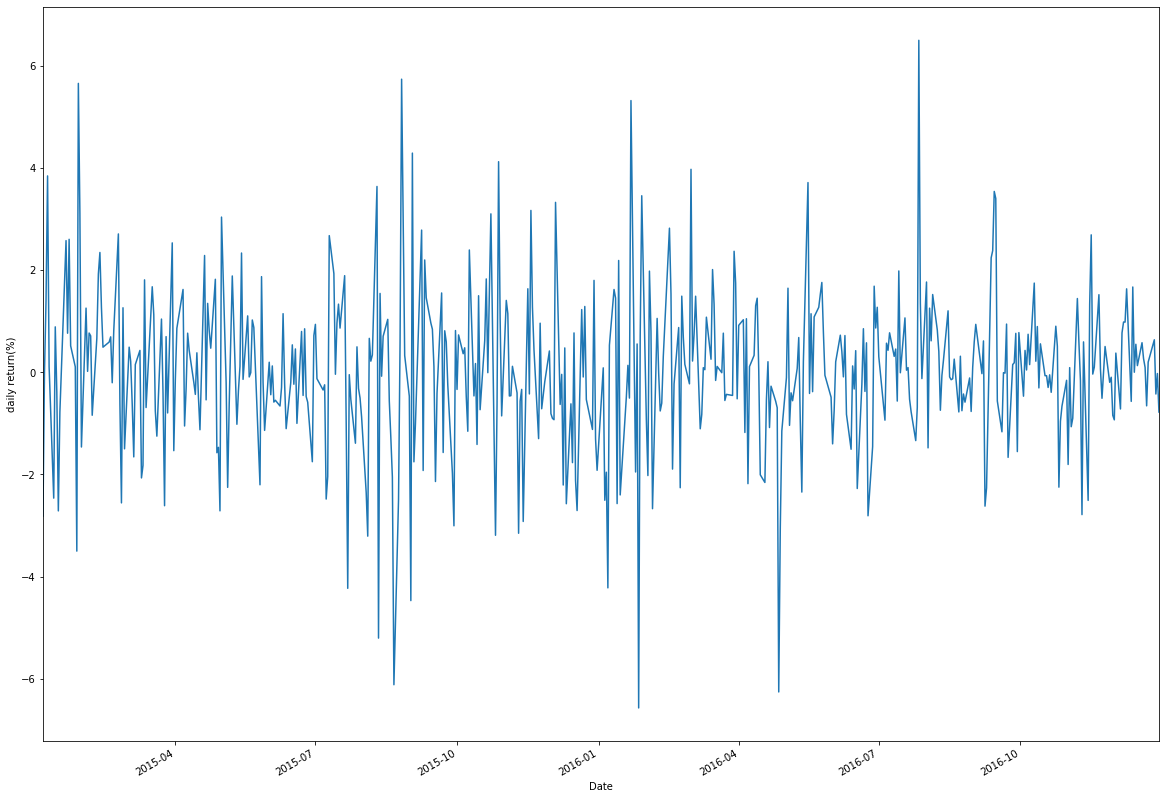

In [372]:
returns.plot(figsize=(20, 15))
plt.ylabel('daily return(%)');

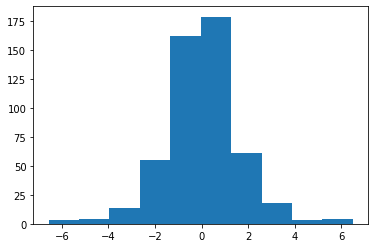

In [374]:
plt.hist(returns)
plt.show()

In the cell below, the model for daily return simulations is shown. Since the daily returns histogram shows bell-shaped distribution, the normal distribution is used for likelihood computation.

This model uses un-informative priors - Uniform distribution for both parameters of the normal distribution ("mu" and 'sigma").

In [376]:
with pm.Model() as model_n:
    
    #Prior
    mu = pm.Uniform('mu', lower=-10, upper=10, testval=0)
    sigma = pm.Uniform('sigma', lower=0, upper=6, testval=0.0001)
    
    #Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sd=sigma, observed = returns.values)
    
    #Posterior
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(10000, chains=3,step=step, start=start, progressbar=True)  
    burned_trace = trace[3000::2]

Multiprocess sampling (3 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 210 seconds.
The number of effective samples is smaller than 10% for some parameters.


C:\Users\jacey\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000282E9EDB108>,
      dtype=object)

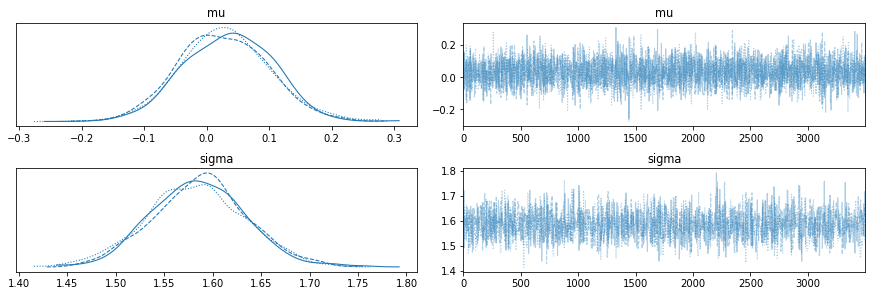

In [377]:
pm.traceplot(burned_trace)
# sampling chains for individual parameters seem well converged and stationary
# Maximum posterior estimate of each variable is very close to the true parameters

C:\Users\jacey\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000282E7408E48>,
      dtype=object)

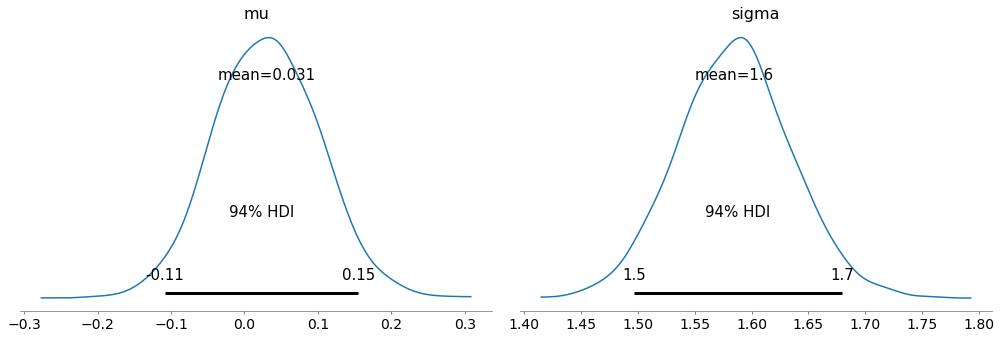

In [378]:
pm.plot_posterior(burned_trace)
#94% probability the belief is between -11% and 15% for the return mean


In [379]:
pm.summary(burned_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.031,0.071,-0.108,0.155,0.001,0.001,3106.0,3032.0,3087.0,3033.0,1.0
sigma,1.585,0.049,1.497,1.680,0.001,0.001,1753.0,1753.0,1744.0,1583.0,1.0


#### Question 2

Improve the model for daily returns given above.
Choose different prior distributions for parameters of the likelihood distribution - Mean $\mu$ and Standard Deviation $\sigma$.

To tune the model, try several different distributions with various spread/dispersion values (for example, Uniform, Normal, HalfNormal) for priors, and different numbers of samples.
By inspecting posterior distribution of parameters, pick the value that produces the smoothest, most convergent chains. 

Present posterior distribution graphically. 

In [426]:
# YOUR CODE HERE
with pm.Model() as model_a:
    mu_a = pm.Normal('mu', mu=0, sigma=1, testval=0)
    sd_a = pm.HalfNormal('sd', sigma=1)
    likelihood_a = pm.Normal('Likelihood', mu=mu_a, sd=sd_a, observed=returns.values)
    #Sampler
    
    Burned_trace1 = pm.sample(1000, tune=1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 71 seconds.


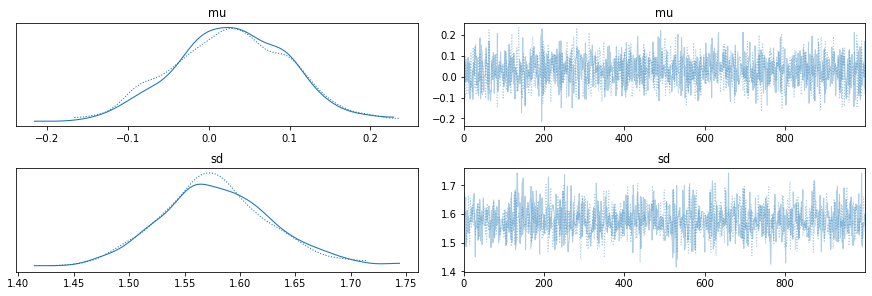

In [429]:
# SHOW TRACE PLOT
pm.traceplot(Burned_trace1);
# sampling chains for individual parameters seem well converged and stationary
# Maximum posterior estimate of each variable is very close to the true parameters
# Q1 model is better than Q2 model

C:\Users\jacey\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000282EC5E6C48>,
      dtype=object)

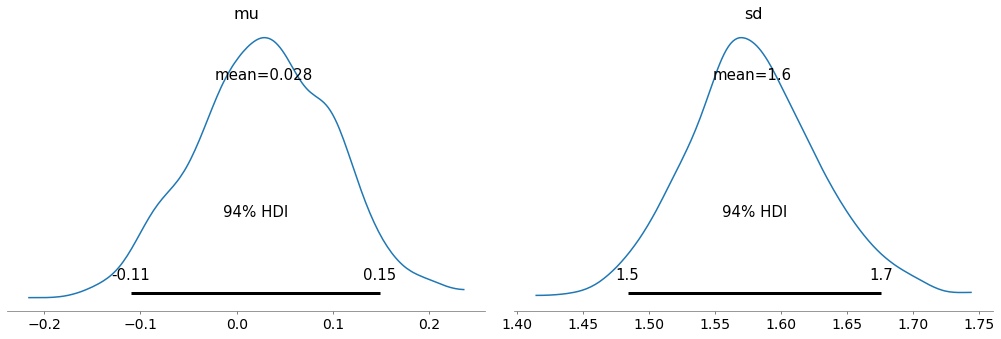

In [430]:
pm.plot_posterior(Burned_trace1)
#94% HDI ,the return is between -11% and 15% of the mean return
#mean estimate to 0.028, a little lower than true population mean

#### Question 3

As a validation check of model performance, predict the distribution of daily returns from the obtained posterior distributions. To generate the data, use the pymc3 function for sampling posterior distribution with an appropriately chosen number of samples from the trace.

Present results of predicted distribution graphically as a histogram.

In [ ]:
# Sample posterior to obtain the distribution of daily returns

In [ ]:
# Plot obtained distribution of daily return

In [431]:
#predicted by two distributions
pr1 = pm.sample_posterior_predictive(burned_trace,samples=500,model=model_n )
pr2 = pm.sample_posterior_predictive(Burned_trace1, samples=500, model=model_a)


C:\Users\jacey\Anaconda3\lib\site-packages\pymc3\sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [432]:
print (pr1)

{'likelihood': array([[ 1.64969785, -1.59148517,  0.9478352 , ...,  1.25050458,
        -0.61693065,  0.14021415],
       [ 4.37827525,  1.42391114, -0.00527062, ..., -0.83991128,
         1.18843403,  0.65412774],
       [ 0.02645838,  1.70973744, -0.9347789 , ...,  0.97218326,
        -2.80978804, -0.96199874],
       ...,
       [-1.59763973, -2.90081781, -1.3041908 , ...,  2.1129887 ,
         0.35596519,  0.48565007],
       [-0.92621829,  0.8597232 ,  3.32838976, ...,  1.74293072,
         0.53090479,  0.78262764],
       [-1.93281997, -2.13028066, -0.01082348, ...,  0.86739786,
         0.01003593, -1.45021437]])}


In [433]:
print (pr2)

{'Likelihood': array([[-1.8433216 , -1.5141816 ,  0.1621493 , ..., -1.3766581 ,
         3.0778176 ,  0.98926601],
       [ 0.6819174 , -0.5534308 ,  0.23884008, ..., -0.53300517,
         1.49710925, -1.54872129],
       [ 1.87383053,  2.48483578, -1.90631248, ...,  1.25812994,
         1.69248596,  0.65197322],
       ...,
       [-0.60073345, -2.79892225, -1.50618528, ...,  0.33823868,
         0.99994568, -2.16793178],
       [ 0.44427025, -0.36348857, -0.53248889, ..., -1.72776823,
         0.51194094, -1.08614131],
       [ 2.35096206, -0.46326698, -1.50592268, ...,  1.45647814,
         2.0505522 , -1.317435  ]])}


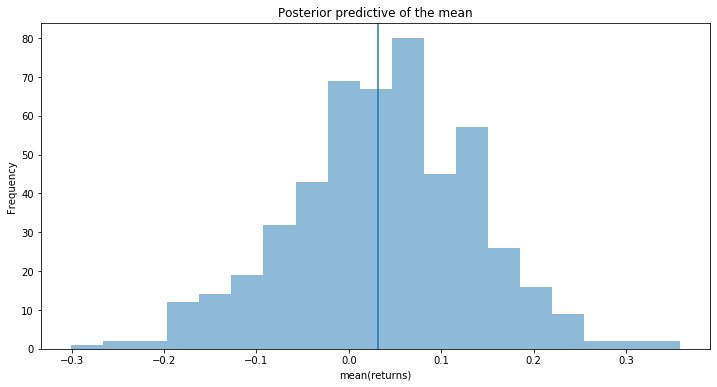

In [434]:
##Plot the Q1 model, posterior mean parameter vs true sample mean
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in pr1['likelihood']], bins=19, alpha=0.5)
ax.axvline(returns.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(returns)', ylabel='Frequency');

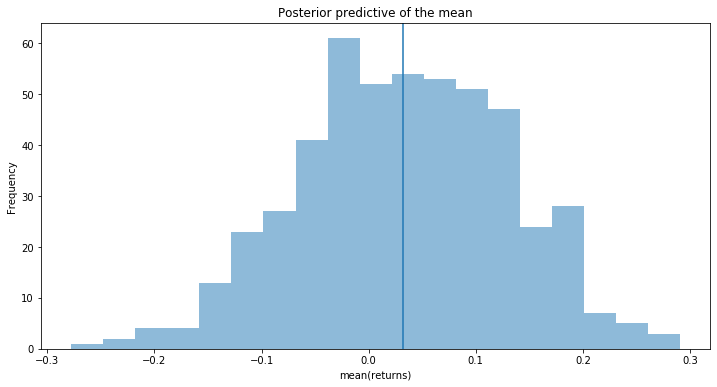

In [435]:
##Plot the Q2 model, prosterior mean parameter vs true sample mean
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in pr2['Likelihood']], bins=19, alpha=0.5)
ax.axvline(returns.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(returns)', ylabel='Frequency');

#### Question 4

(a) Identify the parameter of interest in the prediction model. What would be the best prior distribution to produce these parameters? 

(b) What is the HDI in the posteriors for the parameters you named in 4a? What number of samples was used to build this model? 

(c) Does the data generated when predicting daily returns from posterior distribution deviate significantly from the true distribution?

In [ ]:
# Uniform model is best prior distribution to produce parameters
# by looking at the graph in Q1 and Q2 and Q3

In [ ]:
#Both models show 94% probability the belief is between -11% and 15% for the return mean

In [436]:
np.asarray(pr1['likelihood']).shape
#Q4.b, Q1 Model， pr1 contains 500 generated data sets (containing 503 samples each), 
# each using a different parameter setting from the posterior
# around 500 sample could be used to build this model

(500, 503)

In [437]:
np.asarray(pr2['Likelihood']).shape
# Q4.b, Q2 Model，pr2 contains 500 generated data sets (containing 503 samples each), 
# each using a different parameter setting from the posterior
# around 500 sample could be used to build this model

(500, 503)

In [ ]:
#  by looking at the plots in Q3, daily 
# returns Data predicted  from posterior distribution deviate significantly 
# from the true distribution.
